# Anxiety Analysis with an RNN

In this notebook, a recurrent neural network that performs anxiety analysis is implemented. We will use the communication data in the period of 2020/02/01 - 2020/05/03, together with some static variables to predict the anxiety type of patients. 

### Network Architecture
<code> 
AnxietyRNN(
  (rnn): RNN(2, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=26, out_features=1, bias=True)
  (sig): Sigmoid()
  (criterion): BCELoss()
)
</code>

>**The temporal data will be the input to RNN cells.** The RNN cells will add *recurrent* connections to the network and
 > give us the ability to include information about the *sequence* of observations in the communication data.

>**Then, the RNN outputs will be concatenated with the static features, and together go to a fully-connected layer,
> followed by a ReLU activation, and the fully-connected output layer.**

We apply K-fold cross validation on the data. The main idea is visualised in the above figure. For more details see:
https://machinelearningmastery.com/k-fold-cross-validation/

In [1]:
from IPython.display import Image

Image(url="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png")

In [2]:
# import necessary libraries/methods
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

from src.utils import *
from src.rnn import AnxietyRNNExtended

# set up autoreload
%load_ext autoreload
%autoreload 2

# pandas settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# seaborn settings
sns.set_style("white")
sns.set_palette("tab20")

---
## Load the data

In [3]:
PATH_TO_DATA = None

# load EMA data
df_ema = pd.read_csv(PATH_TO_DATA + "EMA_data.csv")
ema_cols = ["Age", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]

df_ema_enc = pd.read_csv(PATH_TO_DATA + "EMA_data_enc.csv")
ema_cols_enc = ["sc_age", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]

# load communication data and group by patient id
df_temp = pd.read_csv(PATH_TO_DATA + "temp_data.csv")
df_temp["date"] = pd.to_datetime(df_temp["date"], format = "%Y-%m-%d")

In [4]:
# create look-up table for patient ids
patient_lookup = {idx:pid for idx,pid in enumerate(df_temp.user.unique())}

### Pre-process the patient sequences

We want to make sure that our sequences are in good shape for standard processing. That is, our network will expect a standard input length, and so, we'll want to shape our observation sequences into a specific length. In order to do this, we will pad the sequences so that we have sequences of the same length. 

In [5]:
t_features = pad_features(df_temp, ["comm_med", "social_med"])
nt_features = df_ema_enc[ema_cols_enc].values
labels = df_ema_enc.Anxiety_Group.values

---
## K-Fold CV

Typical values for k are k=3, k=5, and k=10, with 10 representing the most common value. This is because, given extensive testing, 10-fold cross-validation provides a good balance of low computational cost and low bias in the estimate of model performance as compared to other k values and a single train-test split.

We will preform 10-Fold CV and in each case we train the model for 100 epochs. 

In [6]:
# define dictionary to store the evaluation metrics and other things to track the training
n_folds = 10
n_epochs = 100
kfold_dic = {
    "split" : np.arange(n_folds),
    "train" : [],
    "test" : [],
    "loss" : [],
    "acc_tr" : [],
    "acc_tst" : [],
    "auc_roc_tr" : [],
    "auc_roc_tst" : [],
    "ap_tr" : [],
    "ap_tst" : [],
}

In [7]:
# perform 10-fold CV
kf = KFold(n_splits=n_folds)

for split_idx, (train_idx, test_idx) in enumerate(kf.split(t_features)):
    print(
        "Split {}: # train obs. = {} \t # test obs = {}".format(
            split_idx, len(train_idx), len(test_idx)
        )
    )
    print("----------")

    # Store the train-test indices
    kfold_dic["train"].append(train_idx)
    kfold_dic["test"].append(test_idx)

    # Train-test split
    train_loader, test_loader = train_test_split_kfold(
        t_features, nt_features, labels, train_idx, test_idx
    )

    # Instantiate the model w/ hyperparams
    net = AnxietyRNNExtended(
        input_dim_rnn=2,
        hidden_dim_rnn=32,
        n_layers_rnn=1,
        input_dim_fc=len(ema_cols_enc),
        hidden_dim_fc=0,
        output_dim=1,
    )

    # Train the network for 50 epochs
    net.train_loop(train_loader, verbose=False, max_nb_epochs=n_epochs, clip=10)

    # Store training loss
    kfold_dic["loss"].append(net.loss_during_training)

    # Compute predictions on both train and test sets
    y_true_tr, y_pred_tr, y_score_tr = net.predict_for_eval(train_loader)
    y_true_tst, y_pred_tst, y_score_tst = net.predict_for_eval(test_loader)

    # Compute evaluation metrics
    kfold_dic["acc_tr"].append(accuracy_score(y_true_tr, y_pred_tr))
    kfold_dic["acc_tst"].append(accuracy_score(y_true_tst, y_pred_tst))

    kfold_dic["auc_roc_tr"].append(roc_auc_score(y_true_tr, y_score_tr))
    kfold_dic["auc_roc_tst"].append(roc_auc_score(y_true_tst, y_score_tst))

    kfold_dic["ap_tr"].append(average_precision_score(y_true_tr, y_score_tr))
    kfold_dic["ap_tst"].append(average_precision_score(y_true_tst, y_score_tst))

Split 0: # train obs. = 85 	 # test obs = 10
----------
Split 1: # train obs. = 85 	 # test obs = 10
----------
Split 2: # train obs. = 85 	 # test obs = 10
----------
Split 3: # train obs. = 85 	 # test obs = 10
----------
Split 4: # train obs. = 85 	 # test obs = 10
----------
Split 5: # train obs. = 86 	 # test obs = 9
----------
Split 6: # train obs. = 86 	 # test obs = 9
----------
Split 7: # train obs. = 86 	 # test obs = 9
----------
Split 8: # train obs. = 86 	 # test obs = 9
----------
Split 9: # train obs. = 86 	 # test obs = 9
----------


---
## Analysing the results

In [8]:
df_kfold = pd.DataFrame(kfold_dic)
df_kfold.to_csv(PATH_TO_RESULTS+"rnn_kfold_eval_auc.csv")

### Training loss evolution 

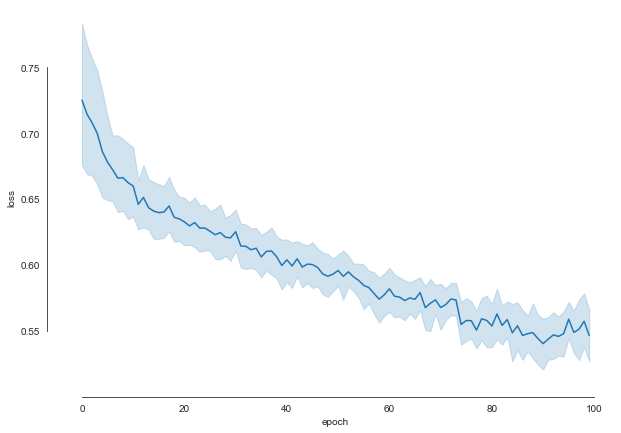

In [9]:
_, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(x = "epoch", y = "loss", data = pd.DataFrame({
    "epoch" : np.tile(np.arange(n_epochs),n_folds),
    "loss" : np.concatenate([x for x in df_kfold.loss]),
}), ax = ax)
sns.despine(offset=10, trim=True, ax=ax)

The models converged in each case, reaching a loss around 0.63 on average.

### Evaluation metrics

Notations:
* ´acc_´ - Accuracy classification score.
* ´auc_roc_´ - Area Under the Receiver Operating Characteristic Curve (ROC AUC). "A receiver operating characteristic
(ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its
discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives
(TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at
various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate."
* ´ap_´ - "The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high
area under the curve represents both high recall and high precision, where high precision relates to a low false positive
 rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning
 accurate results (high precision), as well as returning a majority of all positive results (high recall)."

The ´_tr´ suffix after each metric refers to the training set and ´_tst´ to the test set.

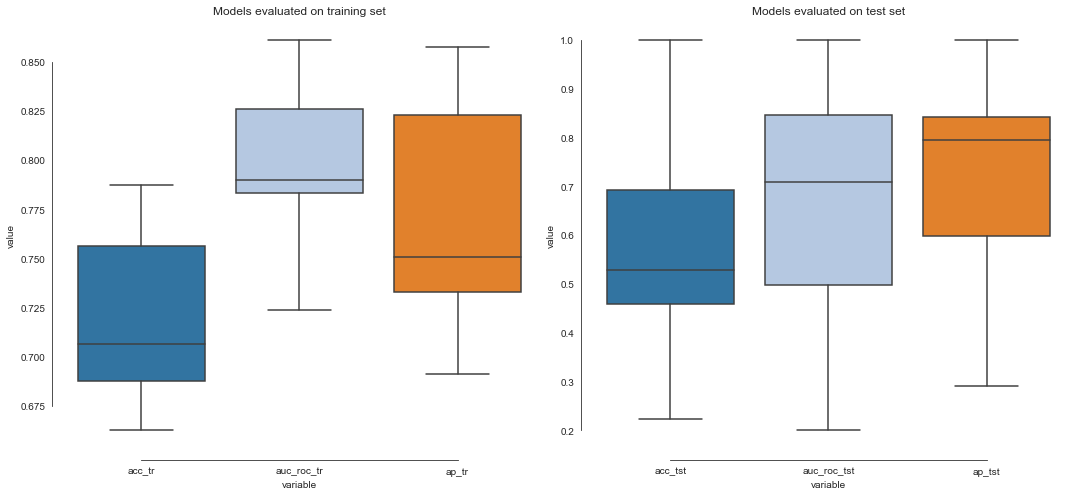

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(df_kfold[["acc_tr", "auc_roc_tr", "ap_tr"]]),
    ax=ax1,
)
sns.despine(offset=10, trim=True, ax=ax1)
ax1.set_title("Models evaluated on training set")

sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(df_kfold[["acc_tst", "auc_roc_tst", "ap_tst"]]),
    ax=ax2,
)
sns.despine(offset=10, trim=True, ax=ax2)
ax2.set_title("Models evaluated on test set")

fig.tight_layout()


In [11]:
df_kfold[df_kfold.columns[4::]].describe()

,acc_tr,acc_tst,auc_roc_tr,auc_roc_tst,ap_tr,ap_tst
count,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.719,0.573,0.796,0.658,0.772,0.717
std,0.048,0.208,0.044,0.248,0.058,0.217
min,0.662,0.222,0.724,0.200,0.691,0.292
25%,0.688,0.458,0.783,0.498,0.733,0.597
50%,0.706,0.528,0.790,0.708,0.751,0.795
75%,0.756,0.692,0.826,0.846,0.823,0.843
max,0.787,1.000,0.861,1.000,0.858,1.000


The model reaches a training accuracy in the 66 - 79% interval, with a mean of 72%.
The mean AUC-ROC is 0.80 and the mean AP is 0.77. We can check in which split did the model perform the worst:

In [12]:
print("Train set")
print("---------")
print(
    "Worst performance splits : {}".format(
        str(df_kfold[df_kfold.acc_tr == df_kfold.acc_tr.min()].split.values).strip("[]")
    )
)
print(
    "Best performance splits: {}".format(
        str(df_kfold[df_kfold.acc_tr == df_kfold.acc_tr.max()].split.values).strip("[]")
    )
)

Train set
---------
Worst performance splits : 7 9
Best performance splits: 2 5


On the test set the mean accuracy is only 57%, the minimum and maximum values are more extreme.
The AUC-ROC and AP scores however, are somewhat better: 0.66 and 0.72 respectively. Splits on which the model performed
worst and best are:

In [13]:
print("Test set")
print("---------")
print(
    "Worst performance splits : {}".format(
        str(df_kfold[df_kfold.acc_tst == df_kfold.acc_tst.min()].split.values).strip(
            "[]"
        )
    )
)
print(
    "Best performance splits: {}".format(
        str(df_kfold[df_kfold.acc_tst == df_kfold.acc_tst.max()].split.values).strip(
            "[]"
        )
    )
)

Test set
---------
Worst performance splits : 6
Best performance splits: 1


It's interesting to see that even though on split 1 the reached training accuracy was not exceptional, the model is able to
generalise very well to the left-out patients, reaching the best test performance. On the other hand, in case of split 6,
the trained model struggles to generalise to the test set.

### Sequence length distributions in the different folds

We can look at the sequence length distribution in each of the split, to analyse whether the performance might depend on them. 

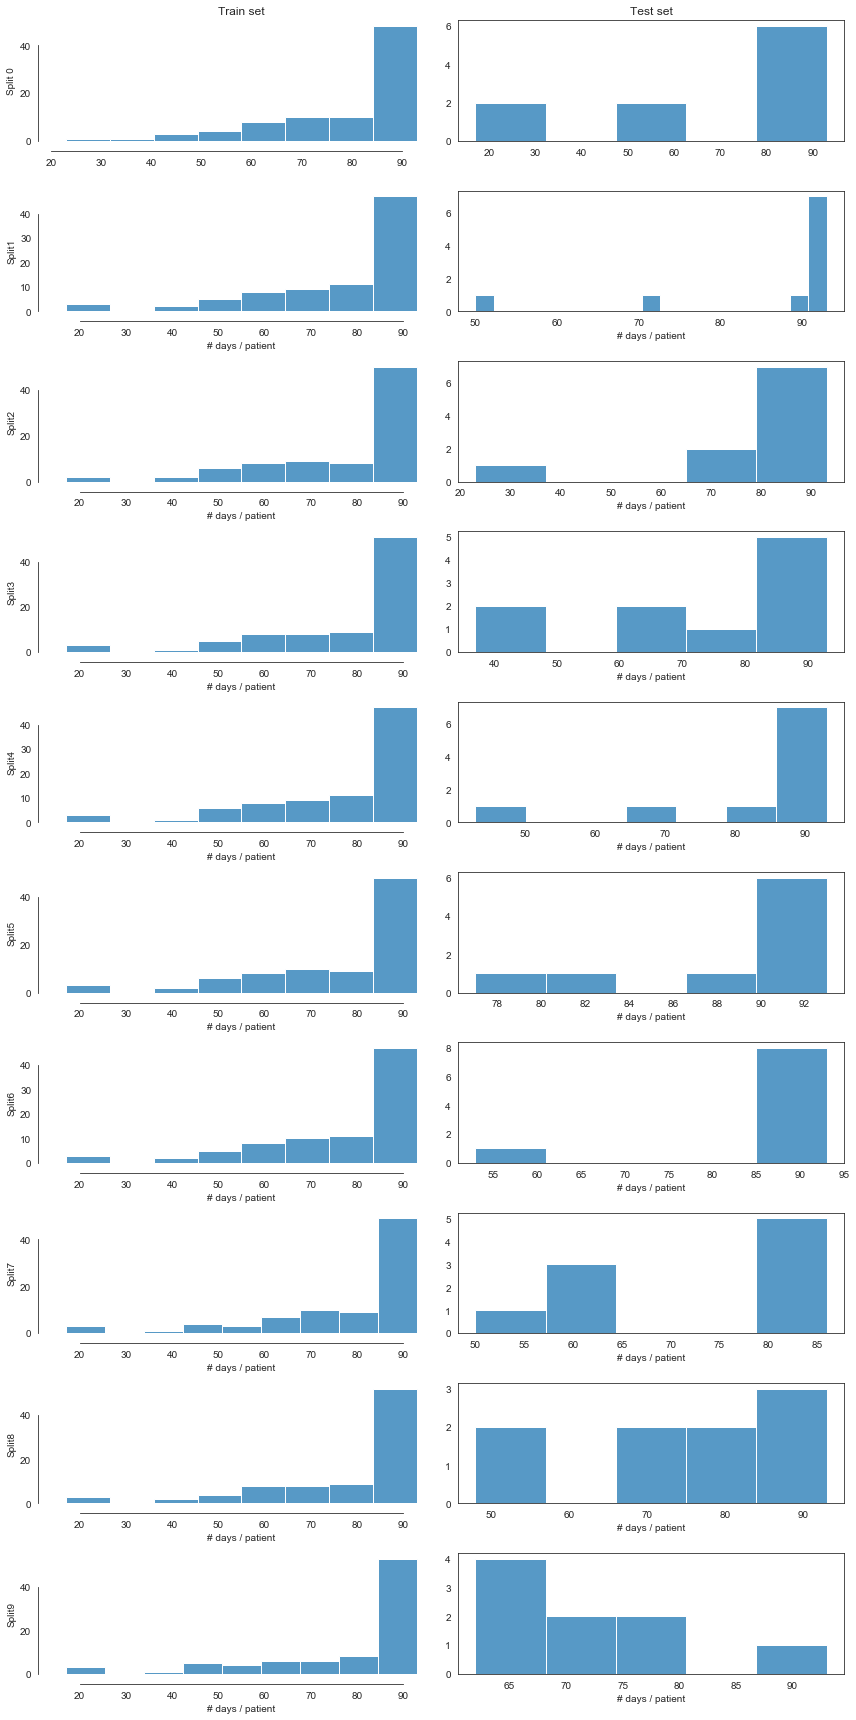

In [14]:
fig, axs = plt.subplots(n_folds, 2, figsize=(12, 24))

for i in range(n_folds):
    sl_count_tr = df_temp[
        df_temp.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 1]])
    ].user.value_counts()
    sns.histplot(data=sl_count_tr, ax=axs[i, 0])
    sns.despine(offset=10, trim=True, ax=axs[i, 0])

    sl_count_tst = df_temp[
        df_temp.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 2]])
    ].user.value_counts()
    sns.histplot(data=sl_count_tst, ax=axs[i, 1])
    

split_idx = 1
for i, ax in enumerate(axs.flat):
    if i == 0:
        ax.set(title="Train set", xlabel="", ylabel="Split 0")
    elif i == 1:
        ax.set(title="Test set", xlabel="", ylabel="")
    elif i % 2 == 0:
        ax.set(xlabel="# days / patient", ylabel="Split" + str(split_idx))
        split_idx += 1
    else:
        ax.set(xlabel="# days / patient", ylabel="")

fig.tight_layout()


It looks like in all the split there are both longer and shorter sequences, so the sequence length doesn't seem to be
the issue regarding the performance.

### Data distribution in the different folds

In [15]:
figures = []
for i in range(n_folds):
    comm_tr = df_temp[df_temp.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 1]])]
    comm_tst = df_temp[
        df_temp.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 2]])
    ]
    ema_tr = df_ema[df_ema.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 1]])]
    ema_tst = df_ema[df_ema.user.isin([patient_lookup[x] for x in df_kfold.iloc[i, 2]])]
    acc_tr = df_kfold.iloc[i, 4]
    acc_tst = df_kfold.iloc[i, 5]

    figures.append(
        plot_kfold_train_test_data(
            comm_tr, comm_tst, ema_tr, ema_tst, ema_cols, acc_tr, acc_tst, i
        )
    )
save_figures_to_pdf(figures, PATH_TO_RESULTS+"rnn_kfold_train_test_splits.pdf")

There are no visual indicators that would suggest why the accuracy on certain test splits is worse than random guessing. 
To see exactly in which individual cases does the model fail, Leave-one-out CV should be performed.